### Homework 7: Logistic Regression
Katie Corcoran

#### 0. Load the Data

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

randomstate = 1000

df = pd.read_csv('credit_card_clean.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,female,university,married,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,female,university,single,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,female,university,single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,female,university,married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,male,university,married,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


#### 1.
 We don't need to scale the features for the logistic regression model because we're not using regularized logistic regression (Ridge, LASSO, or Elastic Net).

#### 2. Feature Variable Types

In [62]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  object 
 3   EDUCATION  30000 non-null  object 
 4   MARRIAGE   30000 non-null  object 
 5   AGE        30000 non-null  int64  
 6   PAY_1      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

ID           30000
LIMIT_BAL       81
SEX              2
EDUCATION        4
MARRIAGE         3
AGE             56
PAY_1           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    22723
BILL_AMT2    22346
BILL_AMT3    22026
BILL_AMT4    21548
BILL_AMT5    21010
BILL_AMT6    20604
PAY_AMT1      7943
PAY_AMT2      7899
PAY_AMT3      7518
PAY_AMT4      6937
PAY_AMT5      6897
PAY_AMT6      6939
DEFAULT          2
dtype: int64

In [63]:
categoricals = ["SEX", "EDUCATION", "MARRIAGE"]
numerics = df.drop(columns=["SEX", "EDUCATION", "MARRIAGE", "DEFAULT"], axis=1, inplace=False).columns

df[numerics]= df[numerics].apply(lambda x: pd.to_numeric(x, errors="coerce"))
df[categoricals]= df[categoricals].apply(lambda x: x.astype("category"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         30000 non-null  int64   
 1   LIMIT_BAL  30000 non-null  float64 
 2   SEX        30000 non-null  category
 3   EDUCATION  30000 non-null  category
 4   MARRIAGE   30000 non-null  category
 5   AGE        30000 non-null  int64   
 6   PAY_1      30000 non-null  int64   
 7   PAY_2      30000 non-null  int64   
 8   PAY_3      30000 non-null  int64   
 9   PAY_4      30000 non-null  int64   
 10  PAY_5      30000 non-null  int64   
 11  PAY_6      30000 non-null  int64   
 12  BILL_AMT1  30000 non-null  float64 
 13  BILL_AMT2  30000 non-null  float64 
 14  BILL_AMT3  30000 non-null  float64 
 15  BILL_AMT4  30000 non-null  float64 
 16  BILL_AMT5  30000 non-null  float64 
 17  BILL_AMT6  30000 non-null  float64 
 18  PAY_AMT1   30000 non-null  float64 
 19  PAY_AMT2   30000 non-null

#### 3. Target Variable

In [64]:
target = df["DEFAULT"]
pd.crosstab(target, target, normalize='all')*100

DEFAULT,0,1
DEFAULT,,
0,77.88,0.00
1,0.00,22.12


Only around 22% of customers defaulted, which makes the target variable relatively unbalanced.

#### 4. Create dummy variables

In [65]:
df = pd.get_dummies(df, drop_first=True, dtype=int)
df

,ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,SEX_male,EDUCATION_highschool,EDUCATION_other,EDUCATION_university,MARRIAGE_other,MARRIAGE_single
0,1,20000.0,24,2,2,-1,-1,-2,-2,3913.0,...,0.0,0.0,0.0,1,0,0,0,1,0,0
1,2,120000.0,26,-1,2,0,0,0,2,2682.0,...,1000.0,0.0,2000.0,1,0,0,0,1,0,1
2,3,90000.0,34,0,0,0,0,0,0,29239.0,...,1000.0,1000.0,5000.0,0,0,0,0,1,0,1
3,4,50000.0,37,0,0,0,0,0,0,46990.0,...,1100.0,1069.0,1000.0,0,0,0,0,1,0,0
4,5,50000.0,57,-1,0,-1,0,0,0,8617.0,...,9000.0,689.0,679.0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,39,0,0,0,0,0,0,188948.0,...,3047.0,5000.0,1000.0,0,1,1,0,0,0,0
29996,29997,150000.0,43,-1,-1,-1,-1,0,0,1683.0,...,129.0,0.0,0.0,0,1,1,0,0,0,1
29997,29998,30000.0,37,4,3,2,-1,0,0,3565.0,...,4200.0,2000.0,3100.0,1,1,0,0,1,0,1
29998,29999,80000.0,41,1,-1,0,0,0,-1,-1645.0,...,1926.0,52964.0,1804.0,1,1,1,0,0,0,0


There are now 27 features after splitting our categorical variables into dummy variables.

#### 5. Split into Train and Test

In [66]:
from sklearn.model_selection import train_test_split
X = df.drop(["DEFAULT"], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=randomstate)
X_train.head()

,ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_male,EDUCATION_highschool,EDUCATION_other,EDUCATION_university,MARRIAGE_other,MARRIAGE_single
25941,25942,210000.0,34,-1,-1,-1,0,0,0,25650.0,...,1943.0,819.0,763.0,2280.0,0,0,0,1,0,0
44,45,40000.0,30,0,0,0,2,0,0,18927.0,...,0.0,2000.0,3000.0,0.0,0,0,0,0,0,1
16295,16296,120000.0,39,0,0,0,0,2,2,116983.0,...,6300.0,3000.0,0.0,3700.0,0,1,0,0,0,0
20232,20233,280000.0,51,-2,-1,-1,-2,-1,-1,390.0,...,4951.0,2408.0,8360.0,6202.0,0,0,0,0,0,0
888,889,90000.0,24,0,0,0,0,0,2,24401.0,...,407.0,673.0,0.0,102.0,0,0,0,1,0,1


#### 6. Logistic Regression

1. Train the model

In [67]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(penalty=None)
logistic.fit(X_train, y_train)

LogisticRegression(penalty=None)

2. Generate predicted probabilities

In [69]:
y_hat = logistic.predict(X_test)
y_hat_probs = logistic.predict_proba(X_test)[:,1]
print(y_hat_probs)

[0.07849687 0.20335928 0.42817098 ... 0.16544823 0.39005504 0.18849942]


3. Plot the histogram

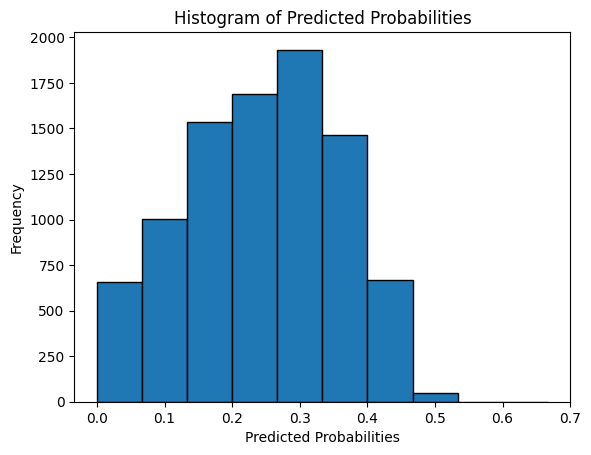

In [70]:
plt.hist(y_hat_probs, bins=10, edgecolor='k')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

From this histogram, it looks like the model is generally predicting a low probability of default. If we set the threshold to 0.8, the model would always predict no default because none of the probabilities reach 0.8. This would lead to a model recall of 0, which is not good.

4. Generate predicted classifications

In [71]:
y_hat_30 = np.where(y_hat_probs>0.30,1,0)
y_hat_60 = np.where(y_hat_probs>0.60,1,0)

If I want to avoid too many false negatives, I should choose threshold 0.3. If I chose threshold 0.6, the model would predict almost all customers as no default, which would lead to a lot of false negatives.

5. df_predictions Data Frame

In [78]:
df_predictions = pd.DataFrame({'y_test': y_test,
                   'y_hat': y_hat,
                   'y_hat_probs': y_hat_probs,
                   'y_hat_30': y_hat_30,
                   'y_hat_60': y_hat_60})
df_predictions.tail()

,y_test,y_hat,y_hat_probs,y_hat_30,y_hat_60
14308,0,0,0.002077,0,0
20266,1,0,0.335123,1,0
15837,0,0,0.165448,0,0
3323,0,0,0.390055,1,0
18825,1,0,0.188499,0,0


#### 7. Performance Metrics

1. Threshold 0.5

In [79]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def my_logistic_report(X_train, y_train, X_test,y_test, threshold=0.5, penalty=None, class_weight=None): # you could make it even more general!
    logistic= LogisticRegression(class_weight=class_weight, penalty=penalty)
    logistic.fit(X_train, y_train)
    probs = logistic.predict_proba(X_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)
    
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,2)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])
    
    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print("-----------------------------------------")
    return cm_labled

In [80]:
my_logistic_report(X_train, y_train, X_test, y_test, threshold=0.5)

-----------------------------------------
Accuracy  = 0.78
Precision = 0.0
Recall    = 0.0
f1_score  = 0.0
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,7008,3
Actual : positive,1989,0


**Accuracy:** The accuracy of 78% means that this model is predicting accurately 78% of the time.\
**Precision:** Precision tells us the percentage of true positives out of all positive predictions. The precision of 0 means the model is not predicting any true defaults.\
**Recall:** Recall tells us the percentage of true positives out of all the actual postiive cases. The recall of 0 means the model is not predicting any defaults.\
**F1-score:** The f1 score is the harmonic mean of precision and recall. Since both precision and recall are 0, the f1 score is also 0, telling us the model has no predictive power.\
**Confusion Matrix:** The confusion matrix tells us how many true and false negatives and true and false positives were predicted. In this case we have a very high number of false negatives (predicting no default when they did default), which makes sense since our model is predicting almost all observations as no default.

No, I do not trust the accuracy for this model because it is skewed by the imbalanced target variable. All other performance metrics indicate that this model has no predictive power.

2. Threshold 0.3

In [76]:
my_logistic_report(X_train, y_train, X_test, y_test, threshold=0.3)

-----------------------------------------
Accuracy  = 0.66
Precision = 0.32
Recall    = 0.5
f1_score  = 0.39
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4900,2111
Actual : positive,986,1003


With a threshold of 0.3 our accuracy goes down, but the precision, recall, and f1 score all go up, and the false negatives go down by 1000. This is consistent with what I said in question 6.4 because the 0.3 threshold reduced the number of false negatives.

#### 8. ROC Curve and AUC Score

LogisticRegression(penalty=None)
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.652


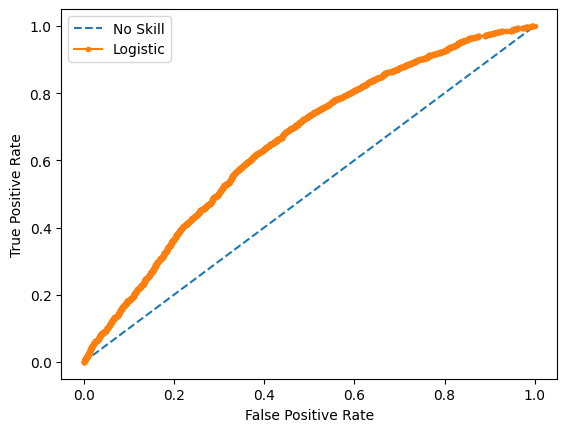

In [77]:
# generate a no skill (ns) prediction and logistic regression (lr) predictions.
ns_probs = [0 for i in range(len(y_test))] # A list of predictions for a "no skill" model, which predicts every observation as the majority class.
print(logistic)
lr_probs = logistic.predict_proba(X_test)[:,1]
# calculating scores for no skill and logistic regression
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs) # false positive rate, true positive rate, thresholds 
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

My model is doing slightly better than the random prediction with an AUC score of 0.652.

#### 9. K-Fold Cross Validation

In [84]:
from sklearn.model_selection import cross_val_score

accuracy_CV5 = cross_val_score(estimator = logistic, X = X_train, y = y_train, cv = 5 , scoring="accuracy")
accuracy_CV10 = cross_val_score(estimator = logistic, X = X_train, y = y_train, cv = 10 , scoring="accuracy")

accuracy_CV5 = round(np.mean(accuracy_CV5), 5)
accuracy_CV10 = round(np.mean(accuracy_CV10), 5)
accuracy = round(accuracy_score(y_test, y_hat), 5)
print(f'''CV5: {accuracy_CV5} 
CV10: {accuracy_CV10}, 
Actual: {accuracy}''')

CV5: 0.77876 
CV10: 0.77871, 
Actual: 0.77867


All of the accuracy scores are very close to each other because, with a default threshold of 0.5, we know that the model will predict virtually all observations as "no default." This means the accuracy is essentially just reflecting what the split of the data is (77% no default and 22% default).